In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter

### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var      

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)


def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None,NW=False):
    
    if NW == True:
        latgridf = latgridi-1 #actually lon
        fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
        tmask = mesh.tmask[0]
        
        lons = data.init_lat[(data.final_section != 0)]
        
        f_lons = mesh.gphif[0,:, latgridf]
        u_lons = mesh.gphiv[0,:, latgridf]
        w_depths = mesh.gdepw_1d
    else:
        latgridf = latgridi-1
        fmask = mesh.fmask[0, :, latgridf]
        tmask = mesh.tmask[0]
            
        lons = data.init_lon[(data.final_section != 0)]
            
        f_lons = mesh.glamf[0, latgridf]
        u_lons = mesh.glamv[0, latgridf]
        w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axn.add_collection(pc)
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel,NW=False):
    
    if NW == True:
        latgridf = latgridi-1 #actually lon
        fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
        tmask = mesh.tmask[0]
        
        lons = data.init_lat[(data.final_section != 0)]
        
        f_lons = mesh.gphif[0,:, latgridf]
        u_lons = mesh.gphiv[0,:, latgridf]
        w_depths = mesh.gdepw_1d
    else:
        latgridf = latgridi-1
        fmask = mesh.fmask[0, :, latgridf]
        tmask = mesh.tmask[0]
            
        lons = data.init_lon[(data.final_section != 0)]
            
        f_lons = mesh.glamf[0, latgridf]
        u_lons = mesh.glamv[0, latgridf]
        w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    try:
        im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    except:
        im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time),cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

In [3]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [4]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['for_jan18','backharoVS_jan18','backrosVS_jan18','backsjcVS_jan18','forharoVS_jan18','forrosVS_jan18','forsjcVS_jan18','backVS_jan18','foradm_jan18']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]

date = dt.datetime(2018,1,1)
enddate = dt.datetime(2018,12,28)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/for_straight_' + date + '_s1t21/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i



In [5]:
dict_secdata = {}

for file in files:
    
    if file not in dict_secdata:
        dict_secdata[file] = {}
    
    
    for section in sectionnum:
        
        if section not in dict_secdata[file]:
            
            dict_secdata[file][section] = {}
            
        for date in dicts[file].keys():
            
            dict_secdata[file][section][date] = get_secdata(dicts[file][date],section)


In [6]:
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

sectransp = {}

for file in files:
    sectransp[file] = {}
    
    for section in sectionnum:
        if section not in sectransp[file]:
            sectransp[file][section] = []
            
        for date in dates:
            try:
                sectransp[file][section].append(dict_sectiontransp[file][date][section])
            except:
                print(date)
                pass

In [7]:
dict_age_ref = {}
dict_age_ts = {}

for file in files:
    ref_dict = {}
    ts_dict = {}
    
    for date in dicts[file].keys():
        if date not in ref_dict:
            ref_dict[date] = []
            ts_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            ref_dict[date].append(np.nanmean(allvar['final_age'][allvar['final_age']>=24]))
            ts_dict[date].append(np.nanmean(allvar['final_age'][allvar['final_age']<24]))
    dict_age_ref[file] = ref_dict
    dict_age_ts[file] = ts_dict

age_ref = {}
age_ts = {}

for file in files:
    if file not in age_ref:
        age_ref[file] = {}
        age_ts[file] = {}
        
    for section in sectionnum:
        if section not in age_ref[file]:
            age_ref[file][section] = []
            age_ts[file][section] = []
            
        for date in dicts[file].keys():
            age_ref[file][section].append(dict_age_ref[file][date][section])
            age_ts[file][section].append(dict_age_ts[file][date][section])
            

In [8]:
ref_transp = {}
ts_transp = {}

for file in files:
    ref_transp[file] = []
    ts_transp[file] = []
    
    for date in dates:      
        ref_transp[file].append(np.sum(dict_secdata[file][0][date]['final_transp'][dict_secdata[file][0][date]['final_age'] >= 24]).values/24)
        ts_transp[file].append(np.sum(dict_secdata[file][0][date]['final_transp'][dict_secdata[file][0][date]['final_age'] < 24]).values/24)

### Salt

In [9]:
ref_salt_final = {}
ts_salt_final = {}
ref_salt_init = {}
ts_salt_init = {}

for file in files:
    ref_salt_final[file] = []
    ts_salt_final[file] = []
    ref_salt_init[file] = []
    ts_salt_init[file] = []
    
    for date in dates:      
        ref_salt_final[file].append(np.mean(dict_secdata[file][0][date]['final_salt'][dict_secdata[file][0][date]['final_age'] >= 24].values))
        ts_salt_final[file].append(np.mean(dict_secdata[file][0][date]['final_salt'][dict_secdata[file][0][date]['final_age'] < 24].values))
        ref_salt_init[file].append(np.mean(dict_secdata[file][0][date]['init_salt'][dict_secdata[file][0][date]['final_age'] >= 24].values))
        ts_salt_init[file].append(np.mean(dict_secdata[file][0][date]['init_salt'][dict_secdata[file][0][date]['final_age'] < 24].values))

In [10]:
salt_final = {}
salt_init = {}


for file in files:
    salt_final[file] = {}
    salt_init[file] = {}
    
    for section in sectionnum:
        salt_final[file][section] = []
        salt_init[file][section] = []
        
        for date in dates:      
            salt_final[file][section].append(np.mean(dict_secdata[file][section][date]['final_salt'].values))
            salt_init[file][section].append(np.mean(dict_secdata[file][section][date]['init_salt'].values))

In [11]:
#Efflux north
ref_sji = np.array(ref_transp['forharoVS_jan18'])+np.array(ref_transp['forrosVS_jan18'])+np.array(ref_transp['forsjcVS_jan18'])
ts_sji = np.array(ts_transp['forharoVS_jan18'])+np.array(ts_transp['forrosVS_jan18'])+np.array(ts_transp['forsjcVS_jan18'])

In [12]:
#Reflux south
ref_vs = ref_transp['for_jan18']
ts_vs = ts_transp['for_jan18']

In [13]:
north_from_vs = 0.5*(np.array(sectransp['backharoVS_jan18'][6])+np.array(sectransp['for_jan18'][6]))+0.5*(np.array(sectransp['for_jan18'][5])+np.array(sectransp['backsjcVS_jan18'][5]))+0.5*(np.array(sectransp['for_jan18'][4])+np.array(sectransp['backrosVS_jan18'][4]))
north_from_adm = 0.5*(np.array(sectransp['foradm_jan18'][6])+np.array(sectransp['backharoVS_jan18'][2]))+0.5*(np.array(sectransp['foradm_jan18'][5])+np.array(sectransp['backsjcVS_jan18'][5]))+0.5*(np.array(sectransp['foradm_jan18'][4])+np.array(sectransp['backrosVS_jan18'][2]))

In [14]:
north_to_sji1 = north_from_adm+north_from_vs

Text(0, 0.5, 'Transort (mSv)')

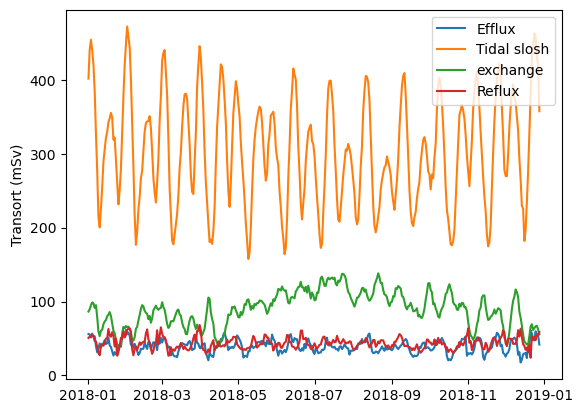

In [15]:
fig,ax = plt.subplots()

ax.plot(datelist_vs,ref_sji/1000,label='Efflux')
ax.plot(datelist_vs,ts_sji/1000,label='Tidal slosh')
ax.plot(datelist_vs,north_to_sji1/1000,label='exchange')
ax.plot(datelist_vs,np.array(ref_vs)/1000,label='Reflux')
ax.legend(loc=1)
ax.set_ylabel('Transort (mSv)')

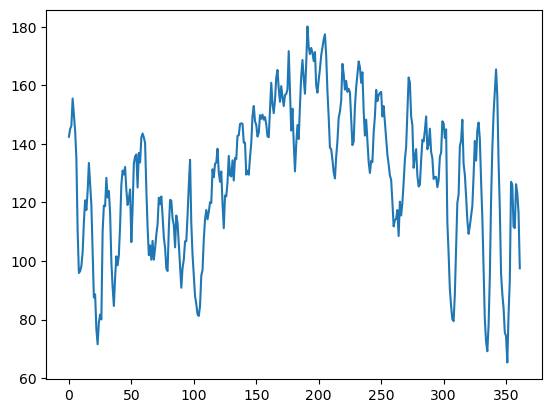

In [16]:
plt.plot(north_to_sji1/1000+ref_sji/1000)

In [17]:
np.mean(north_to_sji1/1000+ref_sji/1000)

129.6301608130756

Very similar to the estimate from MacCready et al. (2021) - 125 mSv

### Salt

In [18]:
salt_to_vs = (np.array(salt_final['for_jan18'][6])*np.array(sectransp['for_jan18'][6]) + np.array(salt_final['for_jan18'][5])*np.array(sectransp['for_jan18'][5]) + np.array(salt_final['for_jan18'][4])*np.array(sectransp['for_jan18'][4]))*1024

### Weighted average

In [19]:
# salt_flux = {}

# for file in files:
#     salt_flux[file] = {}
    
#     for section in sectionnum:
#         salt_flux[file][section] = []
        
#         for date in dict_secdata[file][section].keys():
#            salt_flux[file][section].append(np.sum(dict_secdata[file][section][date]['final_salt'].values*dict_secdata[file][section][date]['final_transp'].values/24)*1024)

In [20]:
# salt_flux['for_jan18'][6][0]/salt_final['for_jan18'][6][0]/1024

In [21]:
salt_flux = {}

for file in files:
    salt_flux[file] = {}
    
    for section in sectionnum:
        salt_flux[file][section] = []
        
        for date in dict_secdata[file][section].keys():
           salt_flux[file][section].append(np.sum((dict_secdata[file][section][date]['final_salt'].values-dict_secdata[file][section][date]['init_salt'].values)*dict_secdata[file][section][date]['final_transp'].values/24)*1024)

In [22]:
salt_ref = {}
salt_ts = {}

for file in files:
    salt_ref[file] = []
    salt_ts[file] = []
        
    for date in dict_secdata[file][0].keys():
        salt_ref[file].append(np.sum(dict_secdata[file][0][date]['final_salt'][dict_secdata[file][0][date]['final_age']>= 24].values*dict_secdata[file][0][date]['final_transp'][dict_secdata[file][0][date]['final_age']>= 24].values/24)*1024)
        salt_ts[file].append(np.sum(dict_secdata[file][0][date]['final_salt'][dict_secdata[file][0][date]['final_age']< 24].values*dict_secdata[file][0][date]['final_transp'][dict_secdata[file][0][date]['final_age']< 24].values/24)*1024)

In [23]:
salt_ref = {}
salt_ts = {}

for file in files:
    salt_ref[file] = []
    salt_ts[file] = []
        
    for date in dict_secdata[file][0].keys():
        salt_ref[file].append(np.sum((dict_secdata[file][0][date]['final_salt'][dict_secdata[file][0][date]['final_age']>= 24].values - dict_secdata[file][0][date]['init_salt'][dict_secdata[file][0][date]['final_age']>= 24].values)*dict_secdata[file][0][date]['final_transp'][dict_secdata[file][0][date]['final_age']>= 24].values/24)*1024)
        salt_ts[file].append(np.sum((dict_secdata[file][0][date]['final_salt'][dict_secdata[file][0][date]['final_age']< 24].values - dict_secdata[file][0][date]['init_salt'][dict_secdata[file][0][date]['final_age']< 24].values)*dict_secdata[file][0][date]['final_transp'][dict_secdata[file][0][date]['final_age']< 24].values/24)*1024)

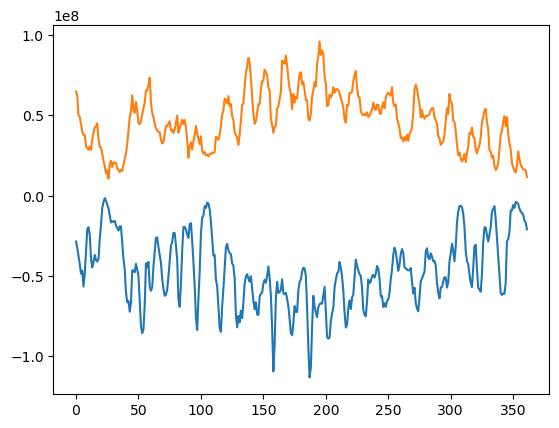

In [24]:
plt.plot(salt_flux['for_jan18'][6])
plt.plot(salt_flux['backharoVS_jan18'][6])

In [25]:
salt_from_vs = np.array(salt_flux['for_jan18'][6]) + np.array(salt_flux['for_jan18'][5]) + np.array(salt_flux['for_jan18'][4])
salt_eff_sji = np.array(salt_ref['forharoVS_jan18']) + np.array(salt_ref['forrosVS_jan18']) + np.array(salt_ref['forsjcVS_jan18'])

Text(0, 0.5, 'Salt flux (Mg/s)')

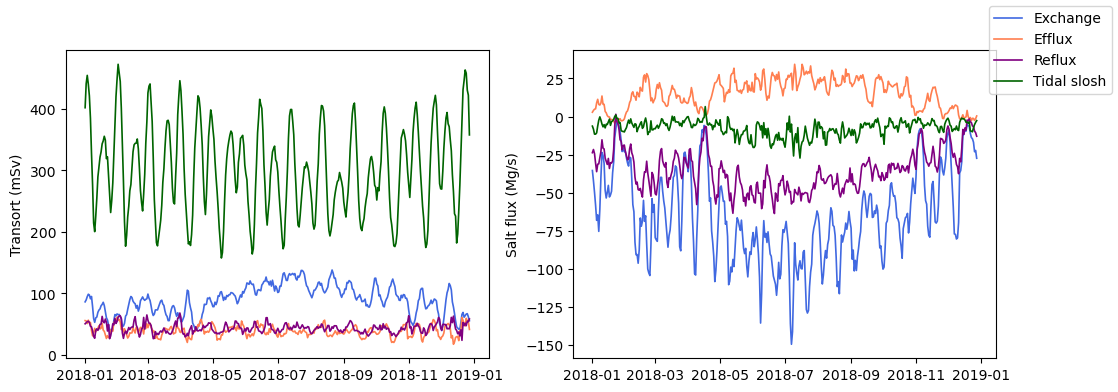

In [41]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(datelist_vs,north_to_sji1/1000,lw=1.2,color='royalblue',label='Exchange')
ax[0].plot(datelist_vs,ref_sji/1000,lw=1.2,color='coral',label='Efflux')
ax[0].plot(datelist_vs,np.array(ref_vs)/1000,color='purple',lw=1.2,label='Reflux')
ax[0].plot(datelist_vs,ts_sji/1000,lw=1.2,color='darkgreen',label='Tidal slosh')
ax[0].xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=2)) # Tick frequency
# ax[0].legend(loc=1)
ax[0].set_ylabel('Transort (mSv)')
fig.legend()

ax[1].plot(datelist_vs,salt_from_vs/1e6,lw=1.2,color='royalblue',label='Exchange')
ax[1].plot(datelist_vs,salt_eff_sji/1e6,lw=1.2,color='coral',label='Efflux')
ax[1].plot(datelist_vs,np.array(salt_ref['for_jan18'])/1e6,color='purple',lw=1.2,label='reflux')
ax[1].plot(datelist_vs,np.array(salt_ts['for_jan18'])/1e6,lw=1.2,color='darkgreen',label='tidal sloshing')
# ax[1].legend()
ax[1].set_ylabel('Salt flux (Mg/s)')

In [42]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/loop_analysis.png')

### Baroclinic

In [28]:
south_from_sji = np.sum([sectransp['forharoVS_jan18'][6],sectransp['forrosVS_jan18'][4],sectransp['forsjcVS_jan18'][5],sectransp['forharoVS_jan18'][2],sectransp['forrosVS_jan18'][2],sectransp['forsjcVS_jan18'][2]],axis=0)